In [58]:
import pandas as pd
import numpy as np
from common import utils
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import time
import re
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
%matplotlib inline

#load training data
twitter_train = pd.read_excel('./StanceDataset/train.xlsx')

#load test data
twitter_test = pd.read_excel('./StanceDataset/test.xlsx')

## Implement baseline - SVM with n-gram features as per the original paper

In [59]:
twitter_train.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos


In [60]:
twitter_test.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


In [63]:
def preprocess_tweets(x):
    """Create preprocessor to retain @, !, #, ? when leveraging CountVectorizer to create word n-grams;
    These characters are likely important to capturing stance given nature of a tweet"""
    
    tokens = x.replace("@"," ATSIGN ").replace("!"," XPT ").replace("#"," HASHTAG ").replace("?"," QUESTM ")
    tokens = re.sub("\d+", "DIGIT", tokens)
    return tokens

In [64]:
def confusion_plot(confusion_matrix, target_names):
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [72]:
def svm_stance(train, test, topic_list):
    """This function takes a list of topics and returns the stance classification f1 score
    of our baseline SVM implementation over the training / test data filtered for the applicable topics"""
    
    #convert topic list to lower case
    for i in range(0,len(topic_list)):
        topic_list[i] = topic_list[i].lower()
    
    #find boolean series of all rows pertaining to the relevant topics
    matches_train = train['Target'].apply(lambda x: x.lower() in topic_list)
    matches_test = test['Target'].apply(lambda x: x.lower() in topic_list)
    
    #carve out tweets
    tweets_train = twitter_train[matches_train]['Tweet']
    tweets_test = twitter_test[matches_test]['Tweet']

    #convert stance to labels for feeding sklearn SVM
    stance_labels_train = np.array(twitter_train[matches_train]['Stance'].apply(lambda x: 
                                                                                2 if x == "FAVOR" else 
                                                                                (1 if x == "NONE" else 0)))

    stance_labels_test = np.array(twitter_test[matches_test]['Stance'].apply(lambda x: 
                                                                             2 if x == "FAVOR" else 
                                                                             (1 if x == "NONE" else 0)))

    
    #pass tweets through pre-processor before feeding to CountVectorizer for word n-gram features
    preprocess_train = tweets_train.apply(lambda x: preprocess_tweets(x))
    preprocess_test = tweets_test.apply(lambda x: preprocess_tweets(x))
    
    #convert training data to sparse matrix for n-gram words
    word_grams = CountVectorizer(ngram_range = (1,3))
    train_nwords = word_grams.fit_transform(preprocess_train)
    
    #convert test data to sparse matrix for n-gram words
    test_nwords = word_grams.transform(preprocess_test)
    
    #convert training data to sparse matrix for n-gram chars
    char_grams = CountVectorizer(ngram_range = (2,5), analyzer = 'char')
    train_nchars = char_grams.fit_transform(tweets_train)
    
    #convert test data to sparse matrix for n-gram chars
    test_nchars = char_grams.transform(tweets_test)
    
    #stack the word and char n-grams
    train_grams = hstack((train_nwords, train_nchars))
    test_grams = hstack((test_nwords, test_nchars))
    
    ##<<WE MAY WANT TO CONSIDER LEAVING OUT THE BELOW COMMENTED OUT CODE IT REALLY SLOWS IT DOWN
    ##F1 SCORES ARE ALSO HIGHER WHEN WE DO NOT LEAVE IT IN THERE>>
    
    #turn counts into presence/absence indicators, as mentioned in the paper
    #train_grams = pd.DataFrame(train_grams.todense())
    #test_grams = pd.DataFrame(test_grams.todense())
    
    #train_grams = train_grams.applymap(lambda x: 1 if x > 1 else x)
    #test_grams = test_grams.applymap(lambda x: 1 if x > 1 else x)
    
    #train_grams = csr_matrix(train_grams.values)
    #test_grams = csr_matrix(test_grams.values)
       
    #train SVM
    start_time_train = time.time()
    #svm = SVC(kernel = 'linear', C = 10)
    svm = LinearSVC(class_weight = 'balanced', C = 100)
    svm.fit(train_grams,stance_labels_train)
    end_time_train = time.time()
    print("Training time:",end_time_train - start_time_train)

    #prediction
    start_time_predict = time.time()
    stance_predict = svm.predict(test_grams)
    end_time_predict = time.time()
    print("Prediction time:", end_time_predict - start_time_predict)

    #calculate f1 score
    f1 = f1_score(stance_labels_test, stance_predict, average = 'macro')
    
    report = classification_report(y_true = stance_labels_test, 
                                        y_pred = stance_predict,
                                        target_names = ['Against', 'None', 'Favor'])
    
    confuse = confusion_matrix(y_true = stance_labels_test, y_pred = stance_predict) 
    
    return f1, report, confuse

Training time: 0.07480025291442871
Prediction time: 0.0011959075927734375
F1 score for atheism: 0.5875675231477987
              precision    recall  f1-score   support

     Against       0.83      0.82      0.83       160
        None       0.45      0.61      0.52        28
       Favor       0.48      0.38      0.42        32

   micro avg       0.73      0.73      0.73       220
   macro avg       0.59      0.60      0.59       220
weighted avg       0.73      0.73      0.73       220



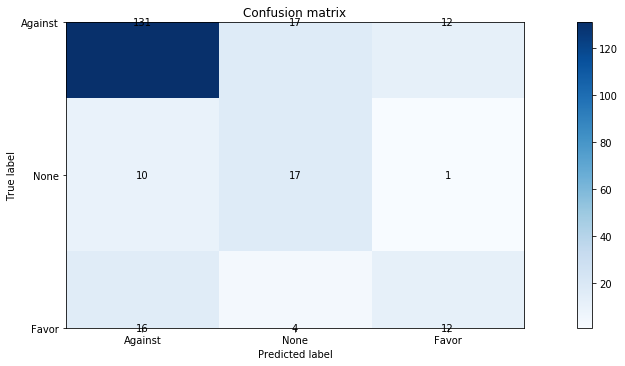

In [73]:
#Atheism
f1_ath, report_ath, confuse_ath = svm_stance(twitter_train, twitter_test, ['Atheism'])
print("F1 score for atheism:", f1_ath)
print(report_ath)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_ath, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.19621610641479492
Prediction time: 0.0017428398132324219
F1 score for Hillary 0.6078356181893714
              precision    recall  f1-score   support

     Against       0.72      0.81      0.77       172
        None       0.72      0.68      0.70        78
       Favor       0.48      0.29      0.36        45

   micro avg       0.70      0.70      0.70       295
   macro avg       0.64      0.59      0.61       295
weighted avg       0.68      0.70      0.69       295



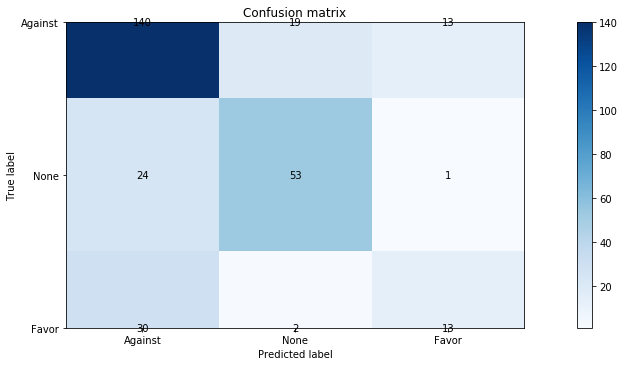

In [75]:
#Hillary
f1_hil, report_hil, confuse_hil = svm_stance(twitter_train, twitter_test, ['Hillary Clinton'])
print("F1 score for Hillary", f1_hil)
print(report_hil)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_hil, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.2569420337677002
Prediction time: 0.0014827251434326172
F1 score for Abortion 0.5677458649594872
              precision    recall  f1-score   support

     Against       0.82      0.66      0.73       189
        None       0.39      0.64      0.49        45
       Favor       0.45      0.52      0.48        46

   micro avg       0.64      0.64      0.64       280
   macro avg       0.55      0.61      0.57       280
weighted avg       0.69      0.64      0.65       280



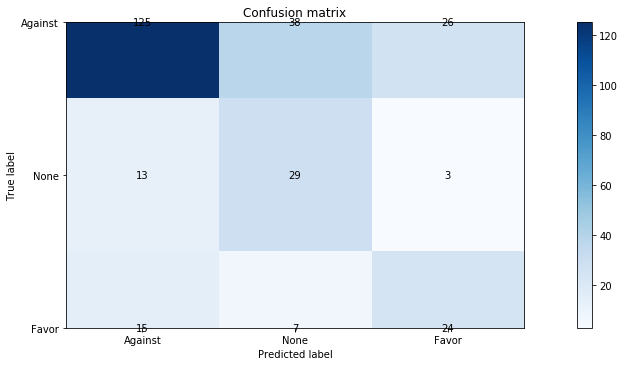

In [76]:
#Abortion
f1_abort, report_abort, confuse_abort = svm_stance(twitter_train, twitter_test, ['Legalization of Abortion'])
print("F1 score for Abortion", f1_abort)
print(report_abort)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_abort, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.07514810562133789
Prediction time: 0.0012111663818359375
F1 score for climate change 0.46084656084656084
              precision    recall  f1-score   support

     Against       0.00      0.00      0.00        11
        None       0.50      0.57      0.53        35
       Favor       0.83      0.87      0.85       123

   micro avg       0.75      0.75      0.75       169
   macro avg       0.44      0.48      0.46       169
weighted avg       0.71      0.75      0.73       169



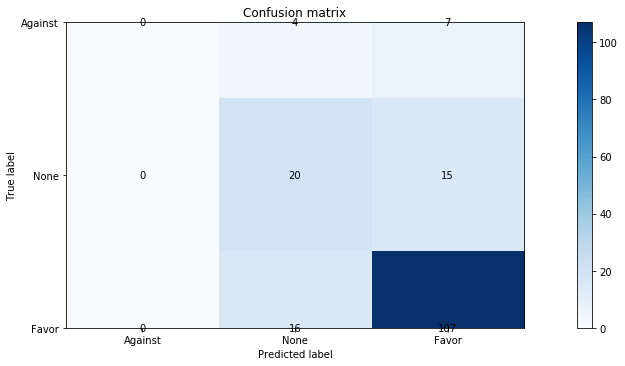

In [77]:
#Climate
f1_clim, report_clim, confuse_clim = svm_stance(twitter_train, twitter_test, ['Climate Change is a Real Concern'])
print("F1 score for climate change", f1_clim)
print(report_clim)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_clim, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.20818400382995605
Prediction time: 0.0014989376068115234
F1 score for feminist mov 0.5454208650256813
              precision    recall  f1-score   support

     Against       0.78      0.62      0.69       183
        None       0.47      0.41      0.44        44
       Favor       0.40      0.69      0.51        58

   micro avg       0.60      0.60      0.60       285
   macro avg       0.55      0.57      0.55       285
weighted avg       0.65      0.60      0.61       285



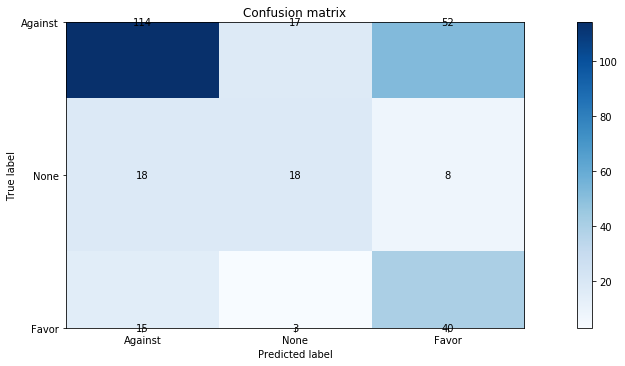

In [78]:
#Feminism
f1_fem, report_fem, confuse_fem = svm_stance(twitter_train, twitter_test, ['Feminist Movement'])
print("F1 score for feminist mov", f1_fem)
print(report_fem)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_fem, ['Against', 'None', 'Favor'])
plt.show()

Training time: 2.0157039165496826
Prediction time: 0.008950948715209961
F1 score for all topics 0.5719316886149118
              precision    recall  f1-score   support

     Against       0.74      0.66      0.69       715
        None       0.46      0.57      0.51       230
       Favor       0.49      0.54      0.51       304

   micro avg       0.61      0.61      0.61      1249
   macro avg       0.56      0.59      0.57      1249
weighted avg       0.63      0.61      0.62      1249



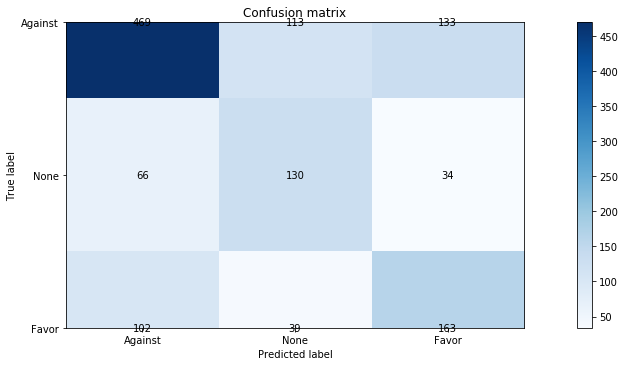

In [79]:
#All
all_tops = ['Hillary Clinton', 'Legalization of Abortion', 'Climate Change is a Real Concern',
           'Feminist Movement', 'Atheism']
f1_all, all_report, confuse_all = svm_stance(twitter_train, twitter_test, all_tops)
print("F1 score for all topics", f1_all)
print(all_report)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_all, ['Against', 'None', 'Favor'])
plt.show()